In [3]:
import numpy as np
import auxiliary as au
from matplotlib import pyplot as plt
from scipy import io
import os
import sys
import h5py
import time
import random
import datetime
from optimal_interpolation import OImerge
import calendar


def box_cox_transform(data, exp=0.25):
    return (data ** exp - 1) / exp


def box_cox_recover(data, exp=0.25):
    dataout = (data * exp + 1) ** (1 / exp)
    dataout[data < -1 / exp] = 0
    return dataout


# basic settings
# y1 = int(sys.argv[3])
# y2 = int(sys.argv[4])
# year = [y1, y2]
year = [1980, 1980]

weightmode = 'RMSE'
vars = ['prcp', 'tmean', 'trange']
# "Gaussian": prcp will be transformed into normal distributions; "Actual": actual space
prcp_space = 'Actual'
hwsize = 2  # 5X5 space window used to support estimation at the center grid
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)

# output path of merged data
path_merge = '/Users/localuser/GMET/merge'

# path of merged reanalysis
# path_bac = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/Reanalysis_merge'
path_bac = '/Users/localuser/GMET/merge'

# path of gridded observations
# path_obs = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout'
path_obs = '/Users/localuser/GMET/merge'

# mask file
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
file_mask = './DEM/NA_DEM_010deg_trim.mat'
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels
nrows, ncols = np.shape(mask)


In [7]:
for y in range(year[0], year[1] + 1):
    for m in range(1):
        print('merging date:', y * 100 + m + 1)
        filemerge = path_merge + '/OImerge_' + str(y * 100 + m + 1) + '.npz'
        if os.path.isfile(filemerge):
            print('file exists')
            continue

        date_cal_start = y * 10000 + (m + 1) * 100 + 1
        date_cal_end = y * 10000 + (m + 1) * 100 + calendar.monthrange(y, m + 1)[1]
        datestr = str(date_cal_start) + '-' + str(date_cal_end)
        oimerge_data = dict()

merging date: 198001


In [16]:
            var='prcp'
            print('variable', var)
            file_bac = path_bac + '/mergedata_' + var + '_' +  str(y * 100 + m + 1) + weightmode + '.npz'
            file_obs = path_obs + '/output_' + datestr + '.npz'

            # load background data (value and error)
            datatemp = np.load(file_bac)
            v_bac = datatemp['merge_data']
            if var == 'tmean' or var == 'trange':
                e_bac = datatemp['merge_error_raw']  # error in actual space
            elif var == 'prcp':
                if prcp_space == 'Actual':
                    e_bac = datatemp['merge_error_raw']
                elif prcp_space == 'Gaussian':
                    if weightmode == 'BMA':
                        e_bac = datatemp['merge_error_bc']
                        v_bac = box_cox_transform(v_bac)
                    elif weightmode == 'RMSE':
                        e_bac = datatemp['merge_error_raw']
                        truth = v_bac - e_bac
                        v_bac = box_cox_transform(v_bac)
                        e_bac = v_bac - box_cox_transform(truth)
            else:
                sys.exit('Unknown variable')
            del datatemp

            # load observation data (value and error)
            datatemp = np.load(file_obs)
            if var == 'tmean' or var == 'trange':
                v_obs = datatemp[var]
                e_obs = datatemp[var + '_err']
            elif var == 'prcp':
                if prcp_space == 'Actual':
                    v_obs = datatemp['pcp_raw']
                    e_obs = datatemp['pcp_err_raw']
                elif prcp_space == 'Gaussian':
                    v_obs = datatemp['pcp_bc']
                    e_obs = datatemp['pcp_err_bc']
            else:
                sys.exit('Unknown variable')
            del datatemp
            v_obs = np.flipud(v_obs)
            e_obs = np.flipud(e_obs)

            ntimes = np.shape(v_bac)[2]

variable prcp


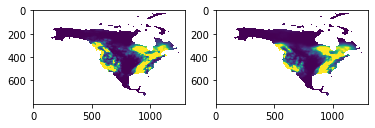

In [34]:
plt.subplot(121)
z=v_obs[:,:,10]
z[np.isnan(mask)]=np.nan
plt.imshow(z)
plt.clim([0,10])

plt.subplot(122)
z=v_bac[:,:,10]
z[np.isnan(mask)]=np.nan
plt.imshow(z)
plt.clim([0,10])

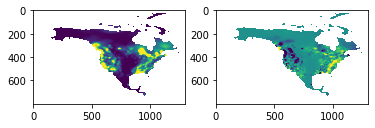

In [38]:
plt.subplot(121)
z=e_obs[:,:,10]
z[np.isnan(mask)]=np.nan
plt.imshow(z)
plt.clim([0,10])

plt.subplot(122)
z=e_bac[:,:,10]
z[np.isnan(mask)]=np.nan
plt.imshow(z)
plt.clim([-2,2])

In [41]:
file='/Users/localuser/Downloads/error_19800101-19800131.npz'
d=np.load(file)
d.files

['pcp_err_stn_bc',
 'pcp_err_stn_raw',
 'tmean_err_stn',
 'trange_err_stn',
 'stninfo']

In [47]:
e=d['trange_err_stn']
e

array([[-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
       [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
       [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
       ...,
       [ 2.1129937e+00,  2.5849261e+00,  8.7993127e-01, ...,
         1.8886231e+00,  3.3178735e-01, -1.2724860e+00],
       [-6.8349409e-01,  1.8779566e+00,  1.4152683e+00, ...,
         7.6724796e+00,  5.1316247e+00,  2.9947710e+00],
       [ 2.6068380e+00,  1.5431528e+00,  6.6852915e-01, ...,
         2.4880970e-01,  2.1858134e+00,  1.5987308e-01]], dtype=float32)

In [48]:
near_file_GMET = '/Users/localuser/GMET/pyGMET_NA/weight_nearstn.npz'
d=np.load(near_file_GMET)
d.files

['near_grid_prcpLoc',
 'near_grid_prcpDist',
 'near_grid_prcpWeight',
 'near_grid_tempLoc',
 'near_grid_tempDist',
 'near_grid_tempWeight',
 'near_stn_prcpLoc',
 'near_stn_prcpDist',
 'near_stn_prcpWeight',
 'near_stn_tempLoc',
 'near_stn_tempDist',
 'near_stn_tempWeight']

In [52]:
        description = '*_realerr_* is weighted mean of estimate - observation from nearby stations. ' \
                      '*_err_* is the root mean of real errors from nearby stations'

In [53]:
    description    

'*_realerr_* is weighted mean of estimate - observation from nearby stations. *_err_* is the root mean of real errors from nearby stations'